### CAM

In [48]:
import ultralytics
from ultralytics import YOLO

In [49]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torchvision.transforms as transforms
from PIL import Image
import io

In [50]:
plt.rcParams["figure.figsize"] = [3.0, 3.0]

In [51]:
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

In [52]:
model = YOLO('models/best.pt')

In [56]:
img = cv2.imread('sampledata/Test (17).JPG')
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255

In [57]:
target_layers =[model.model.model[-4]]


0: 640x640 35 g_ess, 1 grape, 320.3ms
Speed: 0.0ms preprocess, 320.3ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 640)


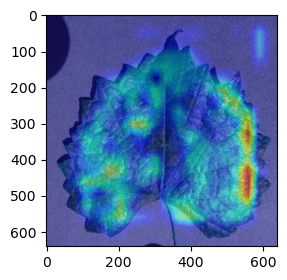

In [58]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

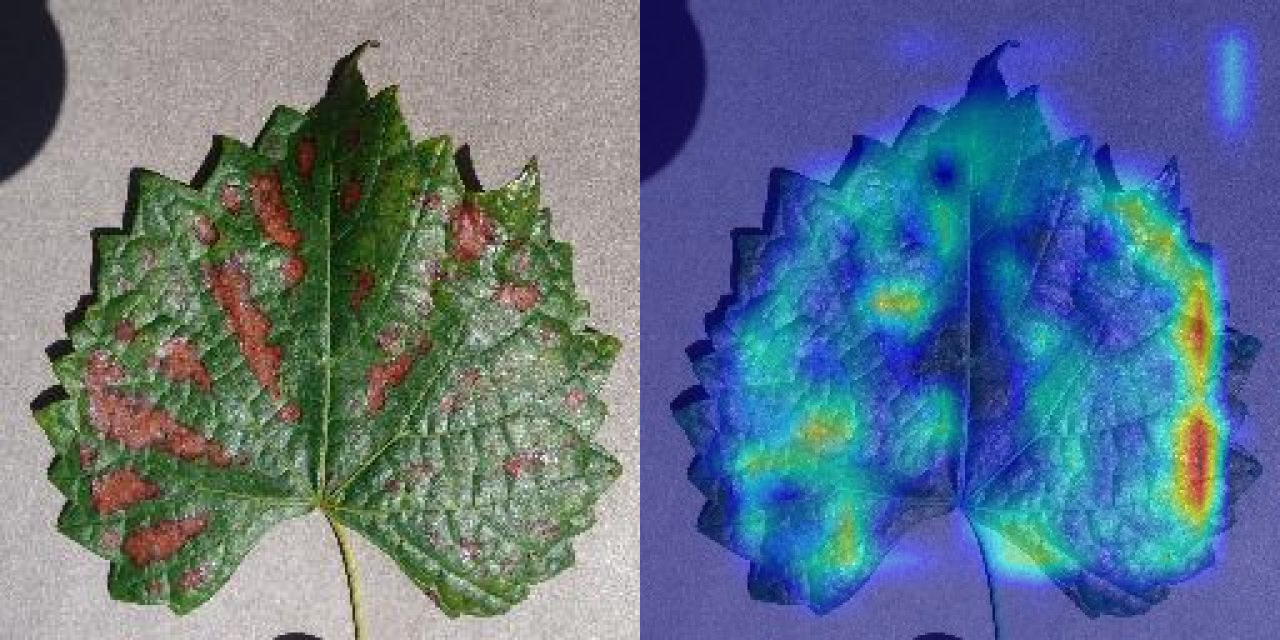

In [59]:
im = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
Image.fromarray(np.hstack((im, cam_image)))

### Saliency Score

In [60]:
def saliency_score(cam, threshold=0.2):
    """
    Compute the saliency score of CAM regions by calculating the average gradient magnitude within those regions.

    Args:
        cam (numpy.ndarray): CAM (Class Activation Map) of the image.
        threshold (float): Threshold value to determine the regions to compute saliency score.

    Returns:
        float: Saliency score.
    """
    # Threshold the CAM to obtain binary mask
    mask = np.uint8(cam > threshold)
    
    # Compute the gradient of the grayscale image
    gradient_x = cv2.Sobel(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    # Compute the saliency score
    saliency_score = np.mean(gradient_magnitude * mask)
    
    return saliency_score

# Calculate Saliency Score
score = saliency_score(grayscale_cam)
print("Saliency Score:", score)


Saliency Score: 37.78956778832161


### Predict IoU score


0: 640x640 2 p_lbs, 1 potato, 253.9ms
Speed: 0.0ms preprocess, 253.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


3
Average IoU: 0.6481320974856476


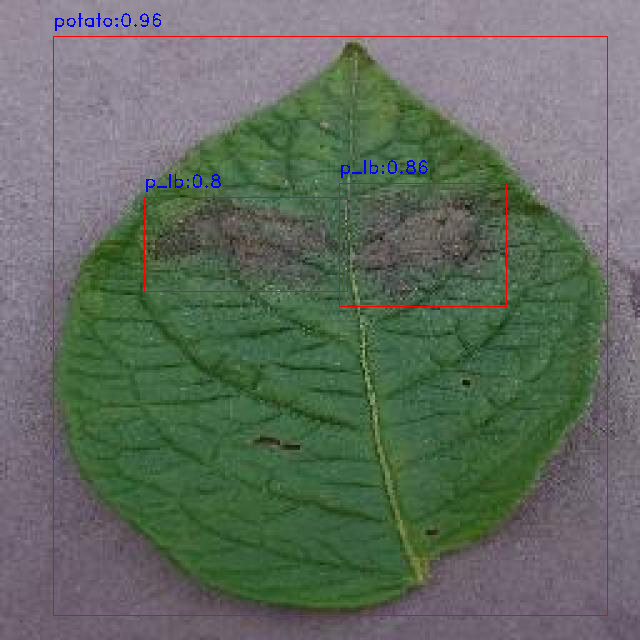

In [32]:
import os
import uuid
import cv2
import numpy as np
from PIL import Image
from collections import Counter
from ultralytics import YOLO
import random

class_list= ['a_br', 'a_cr', 'a_s', 'apple', 'apple_healthy', 'g_br', 'g_es', 'g_lb', 'grape', 'grape_healthy', 'p_eb', 'p_lb', 'potato', 'potato_healthy']
model = YOLO("best.pt") 
conf = 0.10
img_resolution = 640

def calculate_iou(box1, box2):
    # Extract coordinates from boxes
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate coordinates of intersection area
    x_intersection = max(x1, x2)
    y_intersection = max(y1, y2)
    w_intersection = min(x1 + w1, x2 + w2) - x_intersection
    h_intersection = min(y1 + h1, y2 + h2) - y_intersection

    # Calculate area of intersection
    intersection_area = max(0, w_intersection) * max(0, h_intersection)

    # Calculate areas of both boxes
    box1_area = w1 * h1
    box2_area = w2 * h2

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0

    return iou

def load_annotations(annotation_path):
    with open(annotation_path, 'r') as file:
        lines = file.readlines()
        annotations = []
        for line in lines:
            values = line.strip().split()
            cls = int(values[0])
            x_center, y_center, width, height = map(float, values[1:])
            # Convert from normalized coordinates to absolute coordinates
            x = (x_center - width / 2) * img_resolution
            y = (y_center - height / 2) * img_resolution
            w = width * img_resolution
            h = height * img_resolution
            annotations.append([x, y, w, h, cls])
        return annotations

def detect_v8(image_path, annotation_path):
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img) 
    results = model.predict(source=img_np,
                            imgsz=img_resolution,
                            conf=conf,
                            )  
    tensor_list = results[0].boxes.data
    detection = tensor_list.tolist()
    total_products = len(detection)
    print(total_products)
    total_iou = 0
    for det in detection:
        confidence = det[4]
        x, y, w, h, _, cls = [int(d) for d in det]
        cv2.rectangle(img_np, (x, y), (w, h), (255, 0, 0), 1)
        cv2.putText(img_np,f'{str(class_list[cls])}:{str(round(confidence,2))}', (x, y-10), 2, 0.6, (0,0,255), 1)

        # Load ground truth annotations
        annotations = load_annotations(annotation_path)

        # Calculate IoU with ground truth bounding boxes
        for annotation in annotations:
            x_gt, y_gt, w_gt, h_gt, cls_gt = annotation
            iou = calculate_iou([x, y, w, h], [x_gt, y_gt, w_gt, h_gt])
            total_iou += iou

    avg_iou = total_iou / total_products
    print("Average IoU:", avg_iou)

    img_pil = Image.fromarray(np.uint8(img_np))
    display(img_pil)

image_path = "iou/test.jpg"  # Provide the path to your image
annotation_path = "iou/test.txt"  # Provide the path to the corresponding annotation file
detect_v8(image_path, annotation_path)


### Inference time 

In [47]:
import os
import time
import csv
import cv2
import numpy as np
from PIL import Image
from collections import Counter
from ultralytics import YOLO
import random

class_list= ['a_br', 'a_cr', 'a_s', 'apple', 'apple_healthy', 'g_br', 'g_es', 'g_lb', 'grape', 'grape_healthy', 'p_eb', 'p_lb', 'potato', 'potato_healthy']
model = YOLO("best.pt") 
conf = 0.20
img_resolution = 640

def detect_v8(image_path):
    start_time = time.time()  # Start time for measuring inference time
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img) 
    results = model.predict(source=img_np,
                            imgsz=img_resolution,
                            conf=conf,
                            )  
    end_time = time.time()  # End time for measuring inference time
    inference_time = end_time - start_time  # Calculate inference time
    return inference_time

parent_path = "D:/yolo/v8_cam/sampledata"
image_list = [os.path.join(parent_path,i) for i in os.listdir(parent_path)]
random.shuffle(image_list)

total_inference_time = 0  # Initialize total inference time
individual_inference_times = []  # List to store individual inference times

# Collect individual inference times
for image_path in image_list:
    inference_time = detect_v8(image_path)
    individual_inference_times.append(inference_time)
    total_inference_time += inference_time  # Accumulate inference time

# Write to CSV file
csv_path = "D:/yolo/v8_cam/Inference_csv/inference_times.csv"
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image", "Inference Time (seconds)"])  # Header
    for image_path, inference_time in zip(image_list, individual_inference_times):
        writer.writerow([os.path.basename(image_path), inference_time])
    writer.writerow(["Total Inference Time", total_inference_time])  # Write total inference time

print("CSV file created successfully at:", csv_path)



0: 640x640 1 potato_healthy, 316.5ms
Speed: 2.2ms preprocess, 316.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 16 g_ess, 1 grape, 340.0ms
Speed: 13.5ms preprocess, 340.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 24 a_ss, 1 apple, 2 p_ebs, 3 p_lbs, 318.5ms
Speed: 15.6ms preprocess, 318.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 g_br, 12 g_lbs, 1 grape, 1 p_lb, 333.4ms
Speed: 0.0ms preprocess, 333.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 14 p_ebs, 2 p_lbs, 1 potato, 427.0ms
Speed: 3.4ms preprocess, 427.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 p_lbs, 1 potato, 325.2ms
Speed: 15.6ms preprocess, 325.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 apple_healthy, 347.8ms
Speed: 14.0ms preprocess, 347.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 64

CSV file created successfully at: D:/yolo/v8_cam/Inference_csv/inference_times.csv
